In [ ]:
#install spark and java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
#!tar -xvf spark-3.0.0-preview-bin-hadoop3.2.tgz
!pip install -q findspark
!tar xf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install pyspark
#set the PATH 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"
import findspark
findspark.init()

     |████████████████████████████████| 218.4MB 61kB/s 
     |████████████████████████████████| 204kB 44.6MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814406 sha256=fb7c25dcce431fd51f4da031f5759e2dbd14bfa4fdef51f737fd7ee50df32ee1
  Stored in directory: /root/.cache/pip/wheels/1e/5e/6a/17e906c94ec7246f260330a66e44a06a0809033ba2738a74a8
Successfully built pyspark


In [ ]:
#create a Spark Application
from pyspark.sql import SparkSession
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .getOrCreate()

In [ ]:
#import the necessary libries
import pandas as pd
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import StringIndexer,Imputer,MinMaxScaler,VectorAssembler
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,NaiveBayes,MultilayerPerceptronClassifier,LogisticRegression,OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,RegressionEvaluator

#Keystroke_data part

In [ ]:
#read Keysroke csv file
cc=pd.read_csv('fich.csv')
#create keystroke dataframe with spark
df = my_spark.createDataFrame(cc)

In [ ]:
#the stucture of our data
df.printSchema()

root
 |-- HoldTime 1: long (nullable = true)
 |-- HoldTime 2: long (nullable = true)
 |-- HoldTime 3: long (nullable = true)
 |-- HoldTime 4: long (nullable = true)
 |-- HoldTime 5: long (nullable = true)
 |-- HoldTime 6: long (nullable = true)
 |-- HoldTime 7: long (nullable = true)
 |-- HoldTime 8: long (nullable = true)
 |-- HoldTime 9: long (nullable = true)
 |-- HoldTime 10: long (nullable = true)
 |-- HoldTime 11: long (nullable = true)
 |-- HoldTime 12: long (nullable = true)
 |-- HoldTime 13: long (nullable = true)
 |-- HoldTime 14: long (nullable = true)
 |-- HoldTime 15: long (nullable = true)
 |-- HoldTime 16: long (nullable = true)
 |-- HoldTime 17: long (nullable = true)
 |-- HoldTime 18: long (nullable = true)
 |-- HoldTime 19: long (nullable = true)
 |-- HoldTime 20: long (nullable = true)
 |-- HoldTime 21: long (nullable = true)
 |-- HoldTime 22: long (nullable = true)
 |-- HoldTime 23: long (nullable = true)
 |-- HoldTime 24: long (nullable = true)
 |-- HoldTime 25: lo

In [ ]:
print("number of (rows,columns)")
df.count(), len(df.columns)

number of (rows,columns)


(545, 852)

In [ ]:
df.show(10)

+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+

In [ ]:
df.describe().toPandas()

,summary,HoldTime 1,HoldTime 2,HoldTime 3,HoldTime 4,HoldTime 5,HoldTime 6,HoldTime 7,HoldTime 8,HoldTime 9,HoldTime 10,HoldTime 11,HoldTime 12,HoldTime 13,HoldTime 14,HoldTime 15,HoldTime 16,HoldTime 17,HoldTime 18,HoldTime 19,HoldTime 20,HoldTime 21,HoldTime 22,HoldTime 23,HoldTime 24,HoldTime 25,HoldTime 26,release_pressTime 1_2,release_pressTime 1_3,release_pressTime 1_4,release_pressTime 2_3,release_pressTime 2_4,release_pressTime 2_5,release_pressTime 3_4,release_pressTime 3_5,release_pressTime 3_6,release_pressTime 4_5,release_pressTime 4_6,release_pressTime 4_7,release_pressTime 5_6,...,distance 5,distance 6,distance 7,distance 8,distance 9,distance 10,distance 11,distance 12,distance 13,distance 14,distance 15,distance 16,distance 17,distance 18,distance 19,distance 20,distance 21,distance 22,distance 23,distance 24,distance 25,TotalTime,MeanSize,MeanACCX,MeanACCY,MeanACCZ,MeanGravX,MeanGravY,MeanGravZ,MeanGyroX,MeanGyroY,MeanGyroZ,MeanLinAccX,MeanLinAccY,MeanLinAccZ,MeanRotvetX,MeanRotvetY,MeanRotvetZ,MeanPressure,UserID
0,count,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,...,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545,545
1,mean,98.33394495412844,103.73211009174312,100.75229357798165,2.7871559633027525,107.09357798165138,96.24770642201835,92.35045871559633,95.5137614678899,106.18532110091743,97.48990825688074,97.92110091743119,98.99816513761468,99.28440366972477,106.00183486238532,98.72477064220183,103.75412844036697,102.90642201834862,94.99633027522935,3.036697247706422,96.97981651376146,106.01651376146789,97.89357798165138,97.53577981651377,100.56330275229358,95.49724770642202,101.77981651376147,611.3889908256881,1132.7082568807339,1788.6880733944954,417.58715596330273,1073.5669724770642,2261.977981651376,555.2275229357798,1743.6385321100918,2207.4862385321103,1185.6238532110092,1649.4715596330275,2149.977981651376,356.75412844036697,...,773.2069203042475,298.39384804542726,283.6066764081872,521.1615077478066,717.685825053724,512.5657286446428,432.4728446509277,717.1054228749956,384.30706729230377,492.5002141402515,426.48483335332435,130.7759983375147,510.15367612877736,13.884340390199808,414.36910769921644,391.13106433125307,390.4860156787569,444.63613253547936,564.1782514131173,709.5504079926068,608.3323756447013,14357.748623853211,0.011766643936817468,-0.3013934655684186,5.7512921297642725,7.6874827156793755,-0.2754266172205804,5.685299221730688,7.604607775250033,0.02291653349774777,0.019095915778893024,0.005571253096123522,-0.003194750003101289,0.00567168974085601,0.014146776542582808,0.2022494179477301,0.025019555371162672,0.08585261719783766,0.44212950624120695,None
2,stddev,26.679236460625418,26.10220607342648,27.097100711560962,1.0443388104434215,28.75083846357072,23.508976681674937,21.1233275697764,22.34637697592949,29.911090143048984,22.400277148996643,25.121821109238407,24.52868212169359,20.819202349139086,26.16354805119313,23.139233123681468,24.480824323928744,24.271754475099534,23.749612715903893,0.9807579368014459,21.248649523767817,26.295578475907735,20.320041700530016,23.79359591196796,24.656167423445034,26.552121532038303,26.2524360908005,392.1479629917453,495.85531907007004,874.5250990374519,247.3851564737686,703.4221127887002,6266.260165874544,609.9120654241225,6233.744583531132,6245.904199445601,6106.104144788516,6115.434030850029,6135.730388490812,210.86475075867997,...,32.860664857342876,27.93772997428853,32.65708871621702,32.81276969074375,30.296199067684952,30.371973799281406,32.2516297870162,31.52117791194546,31.5850237932979,27.2137650255061,28.556432273689353,24.485458548037105,30.495877795473916,53.50751862886787,35.26497962460354,28.540035422396553,33.3876998570855,28.105934206402488,31.372837843741912,34.20228917269292,31.10681255595369,7944.533692142726,0.00144885

In [ ]:
#create a label_encoder column from userId 
l_indexer = StringIndexer(inputCol="UserID", outputCol="labelIndex")
df = l_indexer.fit(df).transform(df)

In [ ]:
#drop UserId column and use labelIndex column 
df = df.drop('UserID')
df = df.drop('Unnamed: 0')

In [ ]:
#transform all features columns into one column 
#create a list contains our training feature
cols=df.columns
cols.remove("labelIndex")
# Let us import the vector assembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
raw_data=assembler.transform(df)
#raw_data.select("features").show(truncate=False)

In [ ]:
# min max scaler [0-1] //scale all the features to [0,1]
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
raw_data = scaler.fit(raw_data).transform(raw_data)

In [ ]:

# Feature selection using chisquareSelector
'''from pyspark.ml.feature import ChiSqSelector
#css = ChiSqSelector(featuresCol='MinAbs_Scaled_features',outputCol='Aspect',labelCol='labelIndex',fpr=0.05)
css = ChiSqSelector(numTopFeatures=300,featuresCol='scaledFeatures',outputCol='Aspect',labelCol='labelIndex')

raw_data=css.fit(raw_data).transform(raw_data)
#test=css.fit(test).transform(test)
raw_data.select("Aspect").show(5,truncate=False)'''

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#select the feature and the label column
raw_data=raw_data.select(['scaledFeatures','labelIndex'])

In [ ]:
raw_data.show(2)

+--------------------+----------+
|            features|labelIndex|
+--------------------+----------+
|[113.0,105.0,113....|      26.0|
|[106.0,91.0,136.0...|      26.0|
+--------------------+----------+
only showing top 2 rows



In [ ]:
# we should divide our data into training and test sets (20% held out for testing)
(trainingData, testData) = raw_data.randomSplit([0.8, 0.2])

##Decision tree classifier

In [ ]:
dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")

In [ ]:
#using cross validation to evaluate our model
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = dt , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
#average of the model acuuracy for 5 folds
a.avgMetrics

[0.22723300274927863]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 73.7705 
accuracy = 26.2295 


In [ ]:
selected = predictions.select("labelIndex", "probability", "prediction")
for row in selected.collect():
    label, prob, prediction = row
    print("%f --> prob=%s, prediction=%f" % (label, str(max(prob)), prediction))

##random forest

In [ ]:
#using grid search & cross validation to evaluate our model
rf = RandomForestClassifier(labelCol="labelIndex",featuresCol="scaledFeatures")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[90,100,110])\
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = rf , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
#average accuracy for each parameters
a.avgMetrics

[0.73179953279737, 0.7130767965533066, 0.702405573073772, 0.7023925501336657]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 25.8621 
accuracy = 74.1379 


In [ ]:
print(a.bestModel)

RandomForestClassificationModel: uid=RandomForestClassifier_3bb9d8509171, numTrees=90, numClasses=30, numFeatures=851


##Logistic regression

In [ ]:
lr = LogisticRegression(labelCol="labelIndex", featuresCol="scaledFeatures",maxIter=100,regParam=0.01,elasticNetParam=0.1)
#model=lr.fit(trainingData)

In [ ]:

paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = lr , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)


In [ ]:
a.avgMetrics

[0.8539423990089607]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 13.1148 
accuracy = 86.8852 


In [ ]:
trainingSummary=a.bestModel.summary
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
print(len(objectiveHistory))
#for objective in objectiveHistory:
#    print(objective)
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, 100*rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, 100*rate))

objectiveHistory:
101
False positive rate by label:
label 0: 0.0
label 1: 0.0
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
label 18: 0.0
label 19: 0.0
label 20: 0.0
label 21: 0.0
label 22: 0.0
label 23: 0.0
label 24: 0.0
label 25: 0.0
label 26: 0.0
label 27: 0.0
label 28: 0.0
label 29: 0.0
True positive rate by label:
label 0: 100.0
label 1: 100.0
label 2: 100.0
label 3: 100.0
label 4: 100.0
label 5: 100.0
label 6: 100.0
label 7: 100.0
label 8: 100.0
label 9: 100.0
label 10: 100.0
label 11: 100.0
label 12: 100.0
label 13: 100.0
label 14: 100.0
label 15: 100.0
label 16: 100.0
label 17: 100.0
label 18: 100.0
label 19: 100.0
label 20: 100.0
label 21: 100.0
label 22: 100.0
label 23: 100.0
label 24: 100.0
label 25: 100.0
label 26: 100.0
label 27: 100.0
label 28: 100.0
label 29: 100.0


In [ ]:
import statistics

s=[]
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    s.append(rate)

print("falsePositiveRate %s" % (100*statistics.mean(s)))
m=[]
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    m.append(rate)

print("truePositive %s" % (100*statistics.mean(m)))

falsePositiveRate 0.0
truePositive 100.0


In [ ]:
FRR= (1-statistics.mean(m))*100
FAR=100*statistics.mean(s)

In [ ]:
print(FRR,FAR)

0.0 0.0


##deep Learning MultilayerPerceptronClassifier model

In [ ]:
layers = [851,250, 150, 60, 30]
trainer = MultilayerPerceptronClassifier(labelCol="labelIndex", featuresCol="scaledFeatures",maxIter=65, layers=layers, blockSize=128, seed=1234)

In [ ]:
model = trainer.fit(trainingData)

In [ ]:
predictions = model.transform(testData)

In [ ]:
#estimate the accuracy of the prediction

evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 33.6364 
accuracy = 66.3636 


##NaiveBayes model

In [ ]:
nb = NaiveBayes(labelCol="labelIndex", featuresCol="scaledFeatures",smoothing=0.1, modelType="multinomial")
#model = nb.fit(trainingData)

In [ ]:
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = nb , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)


In [ ]:
a.avgMetrics

[0.7224501825124073]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 23.6364 
accuracy = 76.3636 


##One-vs-Rest classifier (a.k.a. One-vs-All)

In [ ]:
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
model = OneVsRest(labelCol="labelIndex", featuresCol="Aspect",classifier=lr)

In [ ]:
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = model , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
a.avgMetrics

[0.9037808124733819]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 11.0092 
accuracy = 88.9908 


#DataAcionList_data Part

In [ ]:
#read DatactioListPart csv file
cc=pd.read_csv('dataAction.csv')

In [ ]:
#create keystroke dataframe with spark
df = my_spark.createDataFrame(cc)

In [ ]:
df.printSchema()

root
 |-- 0: long (nullable = true)
 |-- Mean_Vel_X: double (nullable = true)
 |-- Mean_Vel_Y: double (nullable = true)
 |-- Mean_Vel_Z: double (nullable = true)
 |-- Mean_acc_X: double (nullable = true)
 |-- Mean_acc_Y: double (nullable = true)
 |-- Mean_acc_Z: double (nullable = true)
 |-- Mean_lin_acc_X: double (nullable = true)
 |-- Mean_lin_acc_Y: double (nullable = true)
 |-- Mean_lin_acc_Z: double (nullable = true)
 |-- Mean_gravity_X: double (nullable = true)
 |-- Mean_gravity_Y: double (nullable = true)
 |-- Mean_gravity_Z: double (nullable = true)
 |-- Mean_gyro_X: double (nullable = true)
 |-- Mean_gyro_Y: double (nullable = true)
 |-- Mean_gyro_Z: double (nullable = true)
 |-- Mean_size: double (nullable = true)
 |-- Mean_pressure: double (nullable = true)
 |-- Points_number: long (nullable = true)
 |-- Skewness_acc_X: double (nullable = true)
 |-- Skewness_acc_Y: double (nullable = true)
 |-- Skewness_acc_Z: double (nullable = true)
 |-- skw_lin_acc_X: double (nullable = t

In [ ]:
print("number of (rows,columns)")
df.count(), len(df.columns)

number of (rows,columns)


(5452, 75)

In [ ]:
df.show(2)

+---+-----------------+------------------+------------------+-------------------+-----------------+-----------------+--------------------+--------------------+-------------------+-------------------+-----------------+-----------------+-------------------+-------------------+-------------------+--------------------+------------------+-------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+---------------+-------------+--------------+-------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-

In [ ]:
df.describe().toPandas()

,summary,0,Mean_Vel_X,Mean_Vel_Y,Mean_Vel_Z,Mean_acc_X,Mean_acc_Y,Mean_acc_Z,Mean_lin_acc_X,Mean_lin_acc_Y,Mean_lin_acc_Z,Mean_gravity_X,Mean_gravity_Y,Mean_gravity_Z,Mean_gyro_X,Mean_gyro_Y,Mean_gyro_Z,Mean_size,Mean_pressure,Points_number,Skewness_acc_X,Skewness_acc_Y,Skewness_acc_Z,skw_lin_acc_X,skw_lin_acc_Y,skw_lin_acc_Z,skw_gyro_X,skw_gyro_Y,skw_gyro_Z,skw_gravity_X,skw_gravity_Y,skw_grzvity_Z,Avg_action_duration,Avg_Speed_X,Avg_Speed_Y,Avg_Speed_Z,Standard_dev_acc_X,Standard_dev_acc_Y,Standard_dev_acc_Z,avg_dist,X_midestroke,Y_midestroke,start_Timestamp,end_Timestamp,midstroke_time,acc_midestroke_X,acc_midestroke_Y,acc_midestroke_Z,vel_midestroke_X,vel_midestroke_Y,vel_midestroke_Z,pairwise_disp_vel_X,pairwise_disp_vel_Y,pairwise_disp_vel_Z,pairwise_disp_acc_X,pairwise_disp_acc_Y,pairwise_disp__acc_Z,pairwise_disp_lin_acc_X,pairwise_disp_lin_acc_Y,pairwise_disp_lin_acc_Z,pairwise_disp_gyro_X,pairwise_disp_gyro_Y,pairwise_disp_gyro_Z,pairwise_disp_gravity_X,pairwise_disp_gravity_Y,pairwise_disp_gravity_Z,gravity_modestroke_X,gravity_modestroke_Y,gravity_modestroke_Z,gyro_modestroke_X,gyro_modestroke_Y,gyro_modestroke_Z,Session,TYPE,Action_Data,UserID
0,count,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452,5452
1,mean,2725.5,32.50098960288304,78.24871507696687,97.00735885438519,-0.5302881181630842,5.26512767454466,7.903988778951043,-0.009224461021017236,-6.140147940616793E-4,0.015818458650871097,-0.4948738307884032,5.232169168351482,7.852091330715424,0.03787471496980212,0.030770420083661314,3.326135943789648E-4,0.015505045527006368,0.5253368107276636,7.24468085106383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.7023110785033,-0.004957099405973736,0.04768160335309254,0.07095201832541237,0.18663547909608147,0.25184422044305843,0.40098731306682656,1442.8300906359761,927.6848557434446,1329.2682882660204,1.984129331676449E7,1.984145401907557E7,1.984140523312546E7,-0.5415877372310691,5.295174683356057,7.943871638745135,32.72415581217011,78.53897672043317,97.20835607587155,28.850291014682806,13.271319456822116,15.389098576304459,0.068662058969956,0.18651901398728057,0.4127556410637807,0.02832489721536235,0.09612681870602592,0.2289113308068314,0.019170327556722693,0.022396196987330315,0.005485069702137783,0.010825852870665557,0.009659712310969995,0.007421578278034659,-0.5014706539565469,5.240816061757369,7.844037266575232,0.03512097174685752,0.029886720115790362,0.0010119946844334648,1.5833326808072808E12,None,None,None
2,stddev,1574.0011647602637,20.938715477636723,38.4260935603734,45.0553421750711,1.3855427131016103,1.772473136350108,1.584142936998371,0.23305211726921887,0.4214864787071538,0.6193100758907921,1.3156228841970945,1.737410470302002,1.4568552741669714,0.1916953738854243,0.22917746899984215,0.11958659771839125,0.005202600002431692,0.1362086316632237,8.69923458683288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.78923333190406,0.01567541244496211,0.02981795206880525,0.039513417090114696,0.1839441844063238,0.3508790168092672,0.5020070113236786,1212.8774992443223,400.7828844981692,499.1296969357444,1.5020527393506898E7,1.502051623391125E7,1.5020523033404503E7,1.4272092131065153,1.7978980303862384,1.6813236926002517,21.606544799986274,38.560408947146605,45.13943856721547,71.66549935357023,55.35480358348208,62.551085103800354,0.18958976397282015,0.7268557781673163,2.7709489529297597,0.11982994810774246,0.6212021639976278,2.5037211258278793,0.07868993559885452,0.10520738911899542,0.03320196875923783,0.05487912078365914,0.05667978567873262,0.050502733278480406,1.328275026467939,1.7367947672013186,1.463605891200575,0.23369572757789905,0.2648756944605072,0.13312734367064033,6.066807502520373E7,Non

In [ ]:
### Get count of nan or missing values in our dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+----------+----------+----------+----------+----------+----------+--------------+--------------+--------------+--------------+--------------+--------------+-----------+-----------+-----------+---------+-------------+-------------+--------------+--------------+--------------+-------------+-------------+-------------+----------+----------+----------+-------------+-------------+-------------+-------------------+-----------+-----------+-----------+------------------+------------------+------------------+--------+------------+------------+---------------+-------------+--------------+----------------+----------------+----------------+----------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+--------------------+-----------------------+-----------------------+----

In [ ]:
#delete columns which contains a lot of null values
co=['skw_grzvity_Z','skw_gravity_Y','skw_gravity_X','skw_gyro_Z','skw_gyro_Y','skw_gyro_X','skw_lin_acc_Z','skw_lin_acc_Y','skw_lin_acc_X']
for e in co:
  df = df.drop(e)

In [ ]:
#transform null values in these columns to the average of a column
imputer = Imputer(
    inputCols=['Skewness_acc_X','Skewness_acc_Y','Skewness_acc_Z'], 
    outputCols=['Skewness_acc_X1','Skewness_acc_Y1','Skewness_acc_Z1']
)
df=imputer.fit(df).transform(df)

In [ ]:
#create a label_encoder column fOr userId 
l_indexer = StringIndexer(inputCol="UserID", outputCol="labelIndex")
df = l_indexer.fit(df).transform(df)

In [ ]:
#create a label_encoder column for Type
l_indexer = StringIndexer(inputCol="TYPE", outputCol="TYPE1")
df = l_indexer.fit(df).transform(df)

In [ ]:
#drop the unnecessary column
co1=['Skewness_acc_X','Skewness_acc_Y','Skewness_acc_Z','Unnamed: 0','Action_Data','Session','UserID','TYPE']
for e in co1:
  df = df.drop(e)

In [ ]:
print("number of (rows,columns)")
df.count(), len(df.columns)

number of (rows,columns)


(5452, 64)

In [ ]:
#transform all features columns into one column 
#create a list contains our training feature
cols=df.columns
cols.remove("labelIndex")
# Let us import the vector assembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
raw_data=assembler.transform(df)
#raw_data.select("features").show(truncate=False)

In [ ]:
# min max scaler [0-1] 
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
raw_data = scaler.fit(raw_data).transform(raw_data)

In [ ]:
raw_data=raw_data.select(['scaledFeatures','labelIndex'])

In [ ]:
# we should divide our data into training and test sets (20% held out for testing)
(trainingData, testData) = raw_data.randomSplit([0.8, 0.2],seed=24)

##Decision tree classifier

In [ ]:
dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="scaledFeatures")

In [ ]:
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = dt , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
a.avgMetrics

[0.7767039586699211]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 20.8448 
accuracy = 79.1552 


In [ ]:
print(a.bestModel)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_0abda204ae91, depth=5, numNodes=45, numClasses=29, numFeatures=63


In [ ]:
a.bestModel.save("mod")

##Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="labelIndex",featuresCol="scaledFeatures")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[90,100])\
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = rf , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=10)
a=cv.fit(trainingData)

In [ ]:
a.avgMetrics

[0.7890235952164707, 0.7848053854727847]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 19.4674 
accuracy = 80.5326 


##deep Learning MultilayerPerceptronClassifier model

In [ ]:
layers = [63,50, 40, 29]
trainer = MultilayerPerceptronClassifier(labelCol="labelIndex", featuresCol="scaledFeatures",maxIter=100, layers=layers, blockSize=128, seed=1234)


In [ ]:
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = trainer , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
a.avgMetrics

[0.9811378128930903]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 1.0101 
accuracy = 98.9899 


##NaiveBayes model

In [ ]:
nb = NaiveBayes(labelCol="labelIndex", featuresCol="scaledFeatures",smoothing=0.3, modelType="multinomial")

In [ ]:
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = nb , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
a.avgMetrics

[0.31639886094071384]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 67.5849 
accuracy = 32.4151 


##Logistic regression

In [ ]:
lr = LogisticRegression(labelCol="labelIndex", featuresCol="scaledFeatures",maxIter=400)

In [ ]:
#lr = LogisticRegression()
paramGrid = ParamGridBuilder() \
    .build()
ss=MulticlassClassificationEvaluator(labelCol='labelIndex',metricName="accuracy")
cv = CrossValidator(estimator = lr , estimatorParamMaps=paramGrid,evaluator=ss,numFolds=5)
a=cv.fit(trainingData)

In [ ]:
a.avgMetrics

[0.8174350787446341]

In [ ]:
#estimate the accuracy of the prediction
predictions = a.transform(testData)
evaluator = MulticlassClassificationEvaluator(\
labelCol="labelIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (100 - 100*accuracy))
print("accuracy = %g " % (100*accuracy))

Test Error = 16.6208 
accuracy = 83.3792 


In [ ]:
trainingSummary=a.bestModel.summary
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
print(len(objectiveHistory))
#for objective in objectiveHistory:
#    print(objective)
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, 100*rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, 100*rate))

objectiveHistory:
401
False positive rate by label:
label 0: 0.45731707317073167
label 1: 0.7260891337005508
label 2: 0.6197322756569162
label 3: 0.5454996280684354
label 4: 1.060419235511714
label 5: 0.024354603019970774
label 6: 0.8431703204047217
label 7: 0.5966587112171837
label 8: 0.19083969465648853
label 9: 0.0949667616334283
label 10: 0.6860657676839366
label 11: 0.4018912529550827
label 12: 0.0708215297450425
label 13: 0.09413979759943517
label 14: 0.02354603249352484
label 15: 0.23579344494223062
label 16: 0.07035647279549719
label 17: 0.16420361247947454
label 18: 0.3277920861624912
label 19: 0.09358914365933552
label 20: 0.09350163627863488
label 21: 0.0
label 22: 0.09330534173081409
label 23: 0.0931098696461825
label 24: 0.04653327128897162
label 25: 0.0927643784786642
label 26: 0.0
label 27: 0.046242774566473986
label 28: 0.022999080036798528
True positive rate by label:
label 0: 93.91100702576112
label 1: 92.95392953929539
label 2: 93.61702127659575
label 3: 91.212121212

In [ ]:
import statistics

s=[]
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    s.append(rate)

print("falsePositiveRate %s" % (100*statistics.mean(s)))
m=[]
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    m.append(rate)

print("truePositive %s" % (100*statistics.mean(m)))

falsePositiveRate 0.26950699757181834
truePositive 92.58500619284304


In [ ]:
'''FAR = FPR = FP/(FP + TN)
FRR = FNR = FN/(FN + TP)
where FP: False positive
      FN: False Negative
      TN: True Negative
      TP: True Positive
      fnr = 1-tpr'''
FRR= (1-statistics.mean(m))*100
FAR=100*statistics.mean(s)


In [ ]:
print(FRR,FAR)

7.414993807156966 0.26950699757181834


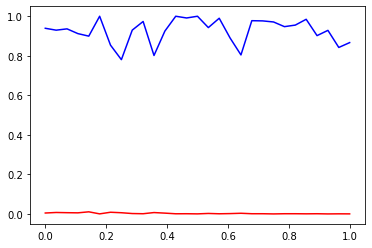

In [ ]:
from numpy import *
t = linspace(0, 1, 29)
plt.plot(t, trainingSummary.falsePositiveRateByLabel, 'r') # plotting t, a separately 
plt.plot(t,  trainingSummary.truePositiveRateByLabel, 'b') # plotting t, b separately 
plt.show()

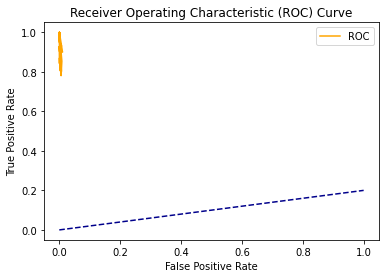

In [ ]:
    plt.plot(trainingSummary.falsePositiveRateByLabel,trainingSummary.truePositiveRateByLabel, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))